## This notebook is part of Hadoop and Spark training delivered by IT-DB group
### SPARK SQL Hands-On Lab
_ by Prasanth Kothuri _

### Hands-On - Data exploration and analysis using Spark SQL
*This demostrates how to use Spark SQL - filter, aggregates and joins*

#### First lets create spark session

In [1]:
# required spark imports
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

In [2]:
conf = SparkConf().setMaster("local").set("spark.driver.memory", "4g")
sc = SparkContext(conf = conf)
spark = SparkSession(sc)

#### Load the datasets

In [3]:
ratings = spark.read.option("header","true").csv("../data/ratings*.csv.gz")

In [4]:
ratings.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    110|   1.0|1425941529|
|     1|    147|   4.5|1425942435|
|     1|    858|   5.0|1425941523|
|     1|   1221|   5.0|1425941546|
|     1|   1246|   5.0|1425941556|
+------+-------+------+----------+
only showing top 5 rows



In [5]:
movies = spark.read.option("header","true").csv("../data/movies.csv.gz")

In [6]:
movies.show(5, False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows



In [7]:
tags = spark.read.option("header","true").csv("../data/tags.csv.gz")

In [8]:
tags.show(5)

+------+-------+----------+----------+
|userId|movieId|       tag| timestamp|
+------+-------+----------+----------+
|     1|    318|  narrated|1425942391|
|    20|   4306|Dreamworks|1459855607|
|    20|  89302|   England|1400778834|
|    20|  89302| espionage|1400778836|
|    20|  89302|      jazz|1400778841|
+------+-------+----------+----------+
only showing top 5 rows



#### Register the dataframes as tables

In [9]:
ratings.createOrReplaceTempView("ratings")
movies.createOrReplaceTempView("movies")
tags.createOrReplaceTempView("tags")

#### SQL Queries!
#### 1) How many movies produced per year?

In [10]:
from pyspark.sql.functions import regexp_extract
movies_year = movies.withColumn("Year",regexp_extract("title",'^(.*) \\(([0-9 \\-]*)\\)$',2))
movies_year.show(5,False)
movies_year.createOrReplaceTempView("movies_year")

+-------+----------------------------------+-------------------------------------------+----+
|movieId|title                             |genres                                     |Year|
+-------+----------------------------------+-------------------------------------------+----+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|1995|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |1995|
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |1995|
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |1995|
|5      |Father of the Bride Part II (1995)|Comedy                                     |1995|
+-------+----------------------------------+-------------------------------------------+----+
only showing top 5 rows



In [11]:
m_yr = spark.sql("select year, count(1) as count from movies_year group by year order by year").toPandas()

In [12]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd

<IPython.core.display.Javascript object>


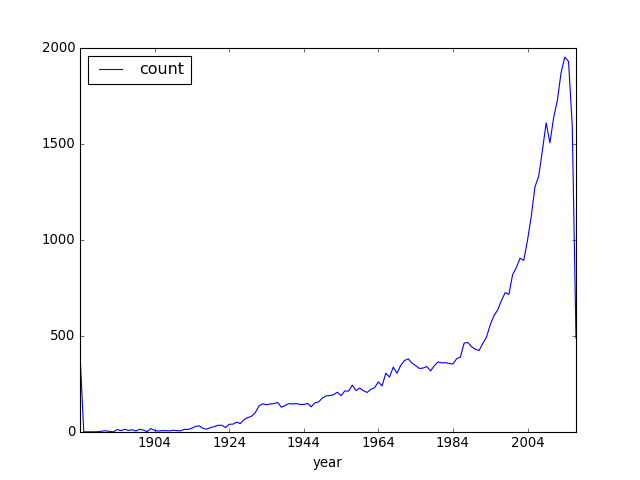

In [13]:
m_yr.plot(x='year',y='count',kind='line')

#### 2) Top movies by number of ratings

In [14]:
spark.sql("select title, count(*) from movies m, ratings r where m.movieId = r.movieId group by title order by 2 desc").show(5)

+--------------------+--------+
|               title|count(1)|
+--------------------+--------+
| Forrest Gump (1994)|   91921|
|Shawshank Redempt...|   91082|
| Pulp Fiction (1994)|   87901|
|Silence of the La...|   84078|
|  Matrix, The (1999)|   77960|
+--------------------+--------+
only showing top 5 rows



#### What happened in the background? How did the join happen?
#### How is the query optimised? Can we get more information?

In [15]:
spark.sql("select title, count(*) from movies m, ratings r where m.movieId = r.movieId group by title order by 2 desc").explain(True)

== Parsed Logical Plan ==
'Sort [2 DESC NULLS LAST], true
+- 'Aggregate ['title], ['title, unresolvedalias('count(1), None)]
   +- 'Filter ('m.movieId = 'r.movieId)
      +- 'Join Inner
         :- 'UnresolvedRelation `movies`, m
         +- 'UnresolvedRelation `ratings`, r

== Analyzed Logical Plan ==
title: string, count(1): bigint
Sort [count(1)#97L DESC NULLS LAST], true
+- Aggregate [title#20], [title#20, count(1) AS count(1)#97L]
   +- Filter (movieId#19 = movieId#1)
      +- Join Inner
         :- SubqueryAlias m, `movies`
         :  +- Relation[movieId#19,title#20,genres#21] csv
         +- SubqueryAlias r, `ratings`
            +- Relation[userId#0,movieId#1,rating#2,timestamp#3] csv

== Optimized Logical Plan ==
Sort [count(1)#97L DESC NULLS LAST], true
+- Aggregate [title#20], [title#20, count(1) AS count(1)#97L]
   +- Project [title#20]
      +- Join Inner, (movieId#19 = movieId#1)
         :- Project [movieId#19, title#20]
         :  +- Filter isnotnull(movieId#19)
     

#### 3) Highly rated movies

In [16]:
spark.sql("select title, avg(rating) as avg_rating from movies m, ratings r \
            where m.movieId = r.movieId \
            group by title \
            order by 2 desc").show(5, False)

+----------------------------+----------+
|title                       |avg_rating|
+----------------------------+----------+
|Dark Harbor (1999)          |5.0       |
|The Hardy Bucks Movie (2013)|5.0       |
|Hush Little Baby (2007)     |5.0       |
|Jimi Plays Berkeley (2012)  |5.0       |
|Gentleman's Game, A (2002)  |5.0       |
+----------------------------+----------+
only showing top 5 rows



Really? How many reviews contributed to this rating?

In [17]:
spark.sql("select title, avg(rating) as avg_rating, count(*) as count from movies m, ratings r \
            where m.movieId = r.movieId \
            group by title \
            order by 2 desc").show(5, False)

+----------------------------+----------+-----+
|title                       |avg_rating|count|
+----------------------------+----------+-----+
|Dark Harbor (1999)          |5.0       |1    |
|The Hardy Bucks Movie (2013)|5.0       |1    |
|Hush Little Baby (2007)     |5.0       |1    |
|Jimi Plays Berkeley (2012)  |5.0       |1    |
|Gentleman's Game, A (2002)  |5.0       |1    |
+----------------------------+----------+-----+
only showing top 5 rows



Lets only take in account movies that have more than 100 reviews

In [18]:
spark.sql("select title, avg(rating) as avg_rating, count(*) as count from movies m, ratings r \
            where m.movieId = r.movieId \
            group by title \
            having count(*) > 100 \
            order by 2 desc").show(20, False)

+---------------------------------------------------------------------------+------------------+-----+
|title                                                                      |avg_rating        |count|
+---------------------------------------------------------------------------+------------------+-----+
|Planet Earth (2006)                                                        |4.478779840848806 |754  |
|Shawshank Redemption, The (1994)                                           |4.429014514393623 |91082|
|Band of Brothers (2001)                                                    |4.394366197183099 |284  |
|Godfather, The (1972)                                                      |4.339810758717364 |57070|
|Usual Suspects, The (1995)                                                 |4.300188962561792 |59271|
|Human Planet (2011)                                                        |4.271573604060913 |197  |
|Schindler's List (1993)                                                 

#### 4) Top rated movie of every year since 2000

In [19]:
avg_ratings = spark.sql("select year, title, avg(rating) as avg_rating, count(*) as count from movies_year m, ratings r where m.movieId = r.movieId group by year, title having count(*) > 100")
avg_ratings.createOrReplaceTempView("avg_ratings")
spark.sql("select a.year, a.title, avg_rating from avg_ratings a, \
            (select year, max(avg_rating) as max_rating from avg_ratings group by year) m \
            where a.year = m.year \
            and a.avg_rating = m.max_rating \
            and a.year > 2000 \
            order by year").show(20, False)

+----+-----------------------------------------------------+------------------+
|year|title                                                |avg_rating        |
+----+-----------------------------------------------------+------------------+
|2001|Band of Brothers (2001)                              |4.394366197183099 |
|2002|City of God (Cidade de Deus) (2002)                  |4.187872863087181 |
|2003|Lord of the Rings: The Return of the King, The (2003)|4.109477786137315 |
|2004|Voices from the List (2004)                          |4.127272727272727 |
|2005|George Carlin: Life Is Worth Losing (2005)           |4.060509554140127 |
|2006|Planet Earth (2006)                                  |4.478779840848806 |
|2007|Heima (2007)                                         |4.029411764705882 |
|2008|Dark Knight, The (2008)                              |4.182070707070707 |
|2009|Moon (2009)                                          |4.021310264795865 |
|2010|Inception (2010)                  

#### 5) Wordcloud of tags used to describe children movies

In [20]:
!pip install --user wordcloud

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [21]:
from wordcloud import WordCloud, STOPWORDS

In [22]:
children_tags = spark.sql("select tag from tags t, movies m where t.movieId = m.movieId and genres like '%Children%'").toPandas()

<IPython.core.display.Javascript object>


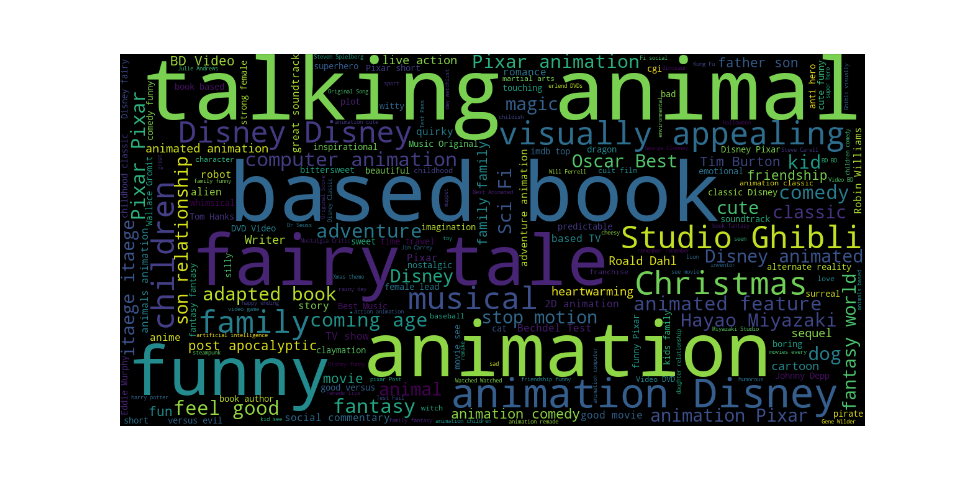

(-0.5, 1199.5, 599.5, -0.5)

In [23]:
# Generate a word cloud image
wordcloud = WordCloud(width=1200,height=600).generate(' '.join(children_tags['tag']))

# Display the generated image
plt.figure(figsize=(12,6))
plt.imshow(wordcloud)
plt.axis("off")